<p><img alt="Colaboratory logo" height="45px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>AnnLite Powered E-commerce Product Search</h1>

<div align="left">
<a href="https://github.com/jina-ai/annlite/blob/main/notebooks/fashion_product_search.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/jina-ai/annlite/blob/main/notebooks/fashion_product_search.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

## What is AnnLite?

`AnnLite` is an  **Approximate Nearest Neighbor Search** (ANNS) library integrated with the Jina ecosystem.


This indexer is recommended to be used when an application requires **search with filters** applied on `Document` tags.
The `filtering query language` is based on [MongoDB's query and projection operators](https://docs.mongodb.com/manual/reference/operator/query/). We currently support a subset of those selectors.
The tags filters can be combined with `$and` and `$or`:

- `$eq` - Equal to (number, string)
- `$ne` - Not equal to (number, string)
- `$gt` - Greater than (number)
- `$gte` - Greater than or equal to (number)
- `$lt` - Less than (number)
- `$lte` - Less than or equal to (number)

For example, we want to search for a product with a price no more than `50$`.
```python
index.search(query, filter={"price": {"$lte": 50}})
```


**Building a Neural Search System for Ecommerce Product Search**

In this tutorial, we will use **annlite** as indexer to build a neural search engine for images of [Fasion Product Image (Small)](https://www.kaggle.com/paramaggarwal/fashion-product-images-small). This examples allows for **appling filters on various product attributes** when performing similarity search.

![image](https://storage.googleapis.com/kaggle-datasets-images/175990/396802/720cd7ceb25eb130d0b873464f734370/data-original.png)



---

## Preliminaries



**Download dataset**

*Skip this if you've already downloaded them.*


In [1]:
!rm -rf data
!pip install gdown

import gdown

# a file
url = "https://drive.google.com/file/d/1p26I3AaFO8bLU1PzDlGKUdM7eBVDrLjm/view?usp=sharing"
output = "fashion.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

!unzip fashion.zip -d data > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1p26I3AaFO8bLU1PzDlGKUdM7eBVDrLjm
To: /content/fashion.zip
100%|██████████| 6.55M/6.55M [00:01<00:00, 5.63MB/s]


**Install dependencies**

In [2]:
!pip install pandas
!pip install Pillow
!pip install matplotlib
!pip install torchvision

!pip install jina
!pip install annlite

**Prepare workspace**

In [3]:
!rm -rf workspace
!mkdir workspace

---

# Using **AnnLite** in E-Commerce Product Image Search


In [4]:
import os
import glob

import pandas as pd

from PIL import Image
from jina import Document, DocumentArray

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

from annlite import AnnLite

os.environ['JINA_LOG_LEVEL'] = 'DEBUG'

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81)
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81)


**Prepare Data**

In [5]:
MAX_NUM_DOCS = 200

df = pd.read_csv('/content/data/data/styles.csv', warn_bad_lines=True, error_bad_lines=False)
df = df.dropna()
df['year'] = df['year'].astype(int)


 (raised from /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882)

 (raised from /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 

In [6]:
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017,Casual,Rasasi Women Blue Lady Perfume


In [34]:
import os

def get_product_docs(max_num: int = MAX_NUM_DOCS):
    da = DocumentArray()
    for index, row in df.iterrows():
        doc_id = row.pop('id')
        doc_uri = f'/content/data/data/{doc_id}.jpg'
        if not os.path.exists(doc_uri):
            continue

        doc = Document(id=str(doc_id), uri=doc_uri, tags=dict(row))
        da.append(doc)
        if len(da) == max_num:
            break
    
    return da

500


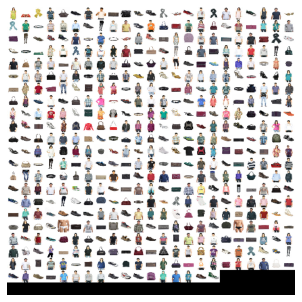

In [35]:
docs = get_product_docs(500)
print(len(docs)) # should be 500
docs.plot_image_sprites()

**Preprocess documents**



In [36]:
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis

docs.apply(preproc)

                           Documents Summary                           
                                                                       
  Length                 500                                           
  Homogenous Documents   True                                          
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'tags')  
                                                                       
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       500              False            
  mime_type   ('str',)       1                False            
  tags        ('dict',)      500              False            
  tensor      ('ndarray',)   500              False            
  uri         ('str',)       500              False

**Encode image documents**

In [37]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50
docs.embed(model, batch_size=8, device='cpu', to_numpy=True)

                                 Documents Summary                                  
                                                                                    
  Length                 500                                                        
  Homogenous Documents   True                                                       
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'tags', 'embedding')  
                                                                                    
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('ndarray',)   500              False            
  id          ('str',)       500              False            
  mime_type   ('str',)       1                False            
  tags        ('dict',)      500              False            
  tensor      ('ndarray',)   500              False            
  uri         ('str',)       500              False

**Index documents into PQLite**

In [38]:
# clear the workspace folder
!rm -rf workspace/*

index = AnnLite(dim=1000, 
               metric='cosine', 
               columns=[
                        ('year', int), 
                        ('baseColour', str), 
                        ('masterCategory', str)
                ], 
               data_path='./workspace')

index.index(docs)

In [39]:
before_year = "2017" #@param [2017, 2018, 2019]
category = "Apparel" #@param ["Apparel", "Footwear"]
color = "Brown" #@param ["White", "Black", "Brown"]



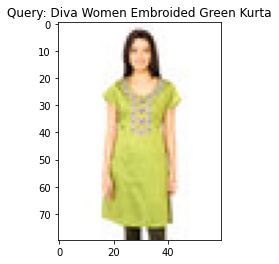

[0] (0.2998480200767517) id: 20166 tags: {'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Shirts', 'baseColour': 'Brown', 'season': 'Winter', 'year': 2011, 'usage': 'Casual', 'productDisplayName': 'Wrangler Men Biker Brown Shirt'}


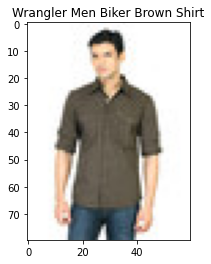

[1] (0.3230225443840027) id: 20105 tags: {'gender': 'Women', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Kurtas', 'baseColour': 'Brown', 'season': 'Fall', 'year': 2011, 'usage': 'Ethnic', 'productDisplayName': 'Diva Women Printed Brown Kurta'}


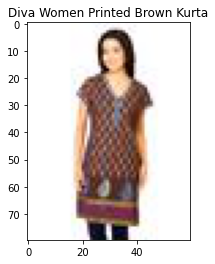

[2] (0.3932587504386902) id: 20110 tags: {'gender': 'Women', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Kurtas', 'baseColour': 'Brown', 'season': 'Fall', 'year': 2011, 'usage': 'Ethnic', 'productDisplayName': 'Diva Women Printed Brown Kurta'}


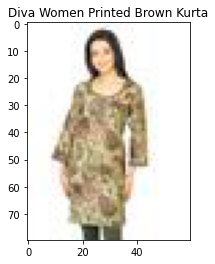

[3] (0.4208575487136841) id: 2052 tags: {'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Tshirts', 'baseColour': 'Brown', 'season': 'Winter', 'year': 2010, 'usage': 'Casual', 'productDisplayName': "Lee Men's Trademark T-shirt"}


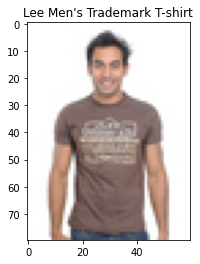

[4] (0.4633525609970093) id: 20258 tags: {'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Tshirts', 'baseColour': 'Brown', 'season': 'Fall', 'year': 2011, 'usage': 'Casual', 'productDisplayName': 'Wrangler Men Polo Charcoal T-shirt'}


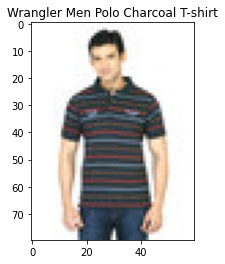

In [42]:
query = docs[0:1]
index.search(query, 
             filter={
                 'year': {'$lte': before_year}, 
                 'masterCategory': {'$eq': category},
                 'baseColour': {'$eq': color}
                }, 
             limit=5, 
             include_metadata=True)


img = Image.open(query[0].uri)
imshow(img)
plt.title(f'Query: {query[0].tags["productDisplayName"]}')
plt.show()
for doc in query:
    for k, match in enumerate(doc.matches):
        print(f'[{k}] ({match.scores["cosine"].value}) id: {match.id} tags: {dict(match.tags)}')
        img = Image.open(match.uri)
        imshow(img)
        plt.title(f'{match.tags["productDisplayName"]}')
        plt.show()

# Using AnnLite executor within Jina Flow

In a jina flow, we can use the executor of [AnnLiteIndexer](https://hub.jina.ai/executor/pn1qofsj), which uses `AnnLite` for indexing documents. 


In [ ]:
from jina import Flow

f = Flow().add(
    uses='jinahub://PQLiteIndexer/latest',
    uses_with={
        'dim': 1000,
        'metric': 'cosine',
        'columns': [
            ('year', 'int'), 
            ('baseColour', 'str'), 
            ('masterCategory', 'str')
        ],
        'include_metadata': True
    },
    uses_metas={'workspace': './workspace'}, 
    install_requirements=True
)

f.plot()

           Flow@2018[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIGV4ZWN1dG9yMDsKZXhlY3V0b3IwL3BlYS0wW2ppbmFodWI6Ly9QUUxpdGVJbmRleGVyL2xhdGVzdF06OjpQRUE7CmVuZDsKZ2F0ZXdheXN0YXJ0W2dhdGV3YXldOjo6R0FURVdBWSAtLT4gZXhlY3V0b3IwOjo6UE9EOwpleGVjdXRvcjA6OjpQT0QgLS0+IGdhdGV3YXllbmRbZ2F0ZXdheV06OjpHQVRFV0FZOwpjbGFzc0RlZiBJTlNQRUNUIHN0cm9rZTojRjI5QzlGCmNsYXNzRGVmIEpPSU5fSU5TUEVDVCBzdHJva2U6I0YyOUM5RgpjbGFzc0RlZiBHQVRFV0FZIGZpbGw6bm9uZSxjb2xvcjojMDAwLHN0cm9rZTpub25lCmNsYXNzRGVmIElOU1BFQ1RfQVVYX1BBU1Mgc3Ryb2tlLWRhc2hhcnJheTogMiAyCmNsYXNzRGVmIEhFQURUQUlMIGZpbGw6IzMy

In [ ]:
# clear the workspace folder
!rm -rf workspace/*

with f:
    f.index(inputs=docs, show_progress=True)

⠋ 0/2 waiting executor0 gateway to be ready...        gateway@2181[D]:setting up sockets...
        gateway@2181[D]:control over ipc:///tmp/tmp8ow78_ah
        gateway@2181[D]:input 0.0.0.0:39731
        gateway@2181[D]:input tcp://0.0.0.0:39731 (ROUTER_BIND) output tcp://0.0.0.0:56489 (ROUTER_BIND) control over ipc:///tmp/tmp8ow78_ah (PAIR_BIND)
        gateway@2018[D]:ready and listening
      executor0@2180[D]:setting up sockets...
      executor0@2180[D]:control over tcp://0.0.0.0:43519
      executor0@2180[D]:input 0.0.0.0:36279
      executor0@2180[D]:input tcp://0.0.0.0:36279 (ROUTER_BIND) output tcp://0.0.0.0:37367 (ROUTER_BIND) control over tcp://0.0.0.0:43519 (PAIR_BIND)
      executor0@2180[D]:recv ControlRequest (STATUS)  from ▸executor0/ZEDRuntime▸⚐
      executor0@2180[D]:skip executor: not data request
      executor0@2018[D]:ready and listening
           Flow@2018[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:46359
	🔒 Private network:	172.28.0

2021-12-16 03:06:54.225 | DEBUG    | pqlite.container:insert:227 - => 100 new docs added


      executor0@2180[D]:output 0.0.0.0:39731
      executor0@2180[D]:recv DataRequest (/index) - (8cba8c91bd3e4ec8a1ddbd5f063862b4)  from gateway▸executor0/ZEDRuntime▸⚐
⠴ Working... ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0:00:00 10% ETA: 4 seconds 

2021-12-16 03:06:54.438 | DEBUG    | pqlite.container:insert:227 - => 100 new docs added


      executor0@2180[D]:recv DataRequest (/index) - (aa7999aaa6af4027a10419f50ac5cb1e)  from gateway▸executor0/ZEDRuntime▸⚐
⠦ Working... ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0:00:00 10% ETA: 4 seconds 

2021-12-16 03:06:54.535 | DEBUG    | pqlite.container:insert:227 - => 100 new docs added


      executor0@2180[D]:recv DataRequest (/index) - (4bbd37454baf4fe881c2fb9597f7a080)  from gateway▸executor0/ZEDRuntime▸⚐
⠧ Working... ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0:00:00 10% ETA: 6 seconds 

2021-12-16 03:06:54.652 | DEBUG    | pqlite.container:insert:227 - => 100 new docs added


      executor0@2180[D]:recv DataRequest (/index) - (c37bff10ea61478f852a00bc1e215f2d)  from gateway▸executor0/ZEDRuntime▸⚐


2021-12-16 03:06:54.742 | DEBUG    | pqlite.container:insert:227 - => 100 new docs added


⠇ Working... ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 0:00:00 20% ETA: 3 seconds       executor0@2180[D]:recv DataRequest (/index) - (3cea32c392c64ce9990d0d7b5a990a22)  from gateway▸executor0/ZEDRuntime▸⚐


2021-12-16 03:06:54.841 | DEBUG    | pqlite.container:insert:227 - => 100 new docs added


⠏ Working... ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 0:00:00 20% ETA: 3 seconds       executor0@2180[D]:recv DataRequest (/index) - (33d50be993214f6d938f4e37ea40a1b3)  from gateway▸executor0/ZEDRuntime▸⚐


2021-12-16 03:06:54.958 | DEBUG    | pqlite.container:insert:227 - => 100 new docs added


      executor0@2180[D]:recv DataRequest (/index) - (855c73a74fe64d5987245f1bbbbfd70d)  from gateway▸executor0/ZEDRuntime▸⚐
⠋ Working... ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 0:00:01 40% ETA: 1 second 

2021-12-16 03:06:55.049 | DEBUG    | pqlite.container:insert:227 - => 100 new docs added


      executor0@2180[D]:recv DataRequest (/index) - (2061b4bdaee043bfb278cbabfcf11628)  from gateway▸executor0/ZEDRuntime▸⚐
⠙ Working... ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 0:00:01 40% ETA: 1 second 

2021-12-16 03:06:55.181 | DEBUG    | pqlite.container:insert:227 - => 100 new docs added


      executor0@2180[D]:recv DataRequest (/index) - (dcb0cd00293843908f66bedfe0a3c7c2)  from gateway▸executor0/ZEDRuntime▸⚐
⠹ Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━ 0:00:01 70% ETA: 0 seconds 

2021-12-16 03:06:55.270 | DEBUG    | pqlite.container:insert:227 - => 100 new docs added


⠼       DONE ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0:00:01 100% ETA: 0 seconds 44 steps done in 1 second
        gateway@2018[D]:waiting for ready or shutdown signal from runtime
        gateway@2018[D]: Cancel runtime
        gateway@2018[D]: Wait to shutdown
        gateway@2181[D]:#sent: 10 #recv: 10 sent_size: 59.4 MB recv_size: 59.4 MB
        gateway@2181[D]:Received message is empty.
        gateway@2018[D]: Joining the process
        gateway@2181[D]: Process terminated
        gateway@2018[D]: Successfully joined the process
        gateway@2018[D]:terminated
        gateway@2018[D]: Joining the process
        gateway@2018[D]: Successfully joined the process
      executor0@2018[D]:waiting for ready or shutdown signal from runtime
      executor0@2018[D]: Cancel runtime
      executor0@2018[D]:Sending TERMINATE command for the 1th time
      executor0@2180[D]:recv ControlRequest (TERMINATE)  from ▸executor0/ZEDRuntime▸⚐
      executor0@2180[D]:Handled #0 during flush of s

⠋ 0/2 waiting executor0 gateway to be ready...        gateway@2321[D]:setting up sockets...
        gateway@2321[D]:control over ipc:///tmp/tmpm6f05h3z
        gateway@2321[D]:input 0.0.0.0:49287
        gateway@2321[D]:input tcp://0.0.0.0:49287 (ROUTER_BIND) output tcp://0.0.0.0:39547 (ROUTER_BIND) control over ipc:///tmp/tmpm6f05h3z (PAIR_BIND)


2021-12-16 03:06:59.485 | INFO     | pqlite.index:_rebuild_index:364 - Rebuild the index of cell-0 (1000 docs)...


        gateway@2018[D]:ready and listening
⠇ 1/2 waiting executor0 to be ready...

2021-12-16 03:07:00.323 | DEBUG    | pqlite.container:insert:227 - => 1000 new docs added


      executor0@2320[D]:setting up sockets...
      executor0@2320[D]:control over tcp://0.0.0.0:43519
      executor0@2320[D]:input 0.0.0.0:36279
      executor0@2320[D]:input tcp://0.0.0.0:36279 (ROUTER_BIND) output tcp://0.0.0.0:37367 (ROUTER_BIND) control over tcp://0.0.0.0:43519 (PAIR_BIND)
⠏ 1/2 waiting executor0 to be ready...      executor0@2320[D]:recv ControlRequest (STATUS)  from ▸executor0/ZEDRuntime▸⚐
      executor0@2320[D]:skip executor: not data request
      executor0@2018[D]:ready and listening
           Flow@2018[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:55429
	🔒 Private network:	172.28.0.2:55429
	🌐 Public address:	34.125.207.64:55429
           Flow@2018[D]:2 Pods (i.e. 2 Peas) are running in this Flow
     GRPCClient@2018[D]:connected to 0.0.0.0:55429
        gateway@2321[D]:output 0.0.0.0:36279
      executor0@2320[D]:recv DataRequest (/search) - (4e23cef8b57b4504b695501df7daf8ba)  from gateway▸executor0/ZEDRuntime▸⚐
      executor0@

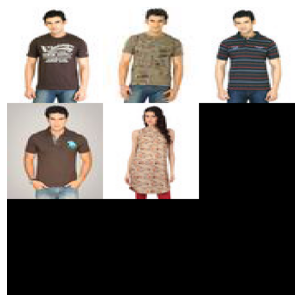

In [ ]:
with f:
    resp = f.search(inputs=query, 
                    return_results=True, 
                    parameters={
                        'filter': {
                            'year': {'$lte': before_year},
                            'masterCategory': {'$eq': category},
                            'baseColour': {'$eq': color}
                        },
                        'limit': 5
                    })

for m in resp[0].docs[0].matches:
    m.set_image_blob_channel_axis(0, -1).set_image_blob_inv_normalization()

resp[0].docs[0].matches.plot_image_sprites()